# band-pass filtering, netcdf case

Multiply by an harmonic signal and low-pass filter

useful [link](https://www.dsprelated.com/showarticle/938.php)

with `apply_ufunc`, an alternative would have been with [xscale](http://xscale.readthedocs.io/en/latest/)


---

In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from scipy import signal
import scipy.ndimage as im

from mitequinox.utils import *

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.start_workers(40)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [7]:
client

Client Scheduler: tcp://10.148.1.19:42852 Dashboard: http://10.148.1.19:8787/status,Cluster Workers: 38 Cores: 152 Memory: 1900.00 GB


---

# 0: variable select and path


In [32]:
v = 'SSU'

# dir where filtered data is stored
out_dir = scratch+'/mit_filtered/'
#out_dir = osi+'/mit_filtered/'

In [6]:
## open files, nc files
#ncdata_dir = datawork+'/mit_nc_t/'
ncdata_dir = scratch+'/mit_nc_t/'
#ncdata_dir = osi+'/mit_nc_t/'

--- 

# 1: One face 

## load data

In [9]:
face = 1

In [9]:
# search for right files, for example: Eta_f01_t*.nc
filenames = sorted(glob(ncdata_dir+v+'_f%02d_t*.nc' %(face)))
print('Number of files available: %d' %len(filenames))
#filenames = filenames[:2] # tmp£
print('Number of files processed: %d' %len(filenames))

grid = xr.open_dataset(osi+'mit_grid_t.nc')
grid = grid.isel(face=face).drop(['XG','YG','i_g','j_g','k','k_u','k_l','k_p1'])
print(grid)

Number of files available: 73
Number of files processed: 73
<xarray.Dataset>
Dimensions:  (i: 4320, j: 4320)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
    XC       (i, j) float32 ...
    YC       (i, j) float32 ...
    rA       (i, j) float32 ...
    Depth    (i, j) float32 ...
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...


In [11]:
%time ds0 = xr.open_mfdataset(filenames, chunks={'i': 20}, concat_dim='time', compat='equals')
#%time ds0 = xr.open_mfdataset(filenames, concat_dim='time', compat='equals')
ds0 = ds0.assign_coords(time_days=ds0['time']/86400.)

ds = ds0

print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

CPU times: user 748 ms, sys: 192 ms, total: 940 ms
Wall time: 946 ms
<xarray.Dataset>
Dimensions:    (i: 4320, j: 4320, time: 8760)
Coordinates:
  * i          (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j          (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    face       int64 1
  * time       (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 ...
    dtime      (time) datetime64[ns] dask.array<shape=(8760,), chunksize=(120,)>
    time_days  (time) float64 66.0 66.04 66.08 66.12 66.17 66.21 66.25 66.29 ...
Data variables:
    SSU        (i, j, time) float32 dask.array<shape=(4320, 4320, 8760), chunksize=(20, 4320, 120)>

 data size: 653.9 GB


In [ ]:
# apply_ufunc requires one chunk along core dimensions
#chunks={'time': len(ds['time'])}
#chunks={'time': len(ds['time']), 'i':2}
#%time ds = ds.chunk(chunks)

In [ ]:
#%time ds = ds.persist()

---

## define the filter


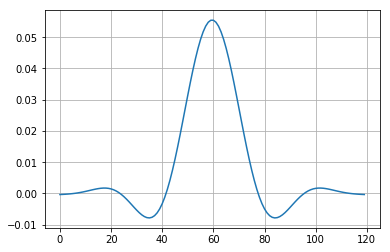

In [13]:
dt = (ds.time[1]-ds.time[0])
Nh = 24*5
h = signal.firwin(Nh, cutoff=[1./(1.5*86400)], pass_zero=True, nyq=1./2/dt, scale=True)

ax = plt.subplot(111)
ax.plot(h)
ax.grid()

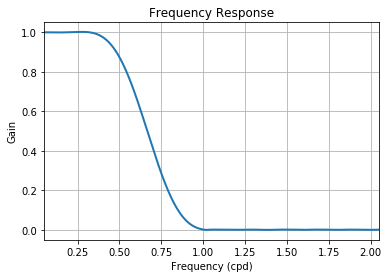

In [14]:
w, hh = signal.freqz(h, worN=8000)
plt.plot((w/np.pi)/2/dt.values*3600*24, abs(hh), linewidth=2)
plt.xlabel('Frequency (cpd)')
plt.ylabel('Gain')
plt.title('Frequency Response')
plt.ylim(-0.05, 1.05)
plt.xlim(0.05, 2.05)
plt.grid(True)

In [15]:
def conv(x, t, omega):
    ''' omega is in cpd
    '''
    if omega>0:
        return im.convolve1d(x * np.cos(2.*np.pi*omega*t), h, axis=2, mode='constant') \
                + 1j * im.convolve1d(x * np.sin(2.*np.pi*omega*t), h, axis=2, mode='constant')
    else:
        lx = x
        return im.convolve1d(lx, h, axis=2, mode='constant')

def filt(v, omega=0, rechunk=True):
    v = v.chunk({'time': len(v.time)})
    return xr.apply_ufunc(conv, v, v.time_days, omega, 
                    dask='parallelized', output_dtypes=[np.complex64],
                    input_core_dims=[['time'],['time'],[]],
                    output_core_dims=[['time']],
                    output_sizes={'time': len(v.time)})
    

---

## filtering @ 1 location

In [16]:
lds = ds.isel(i=slice(5), j=slice(0,100))

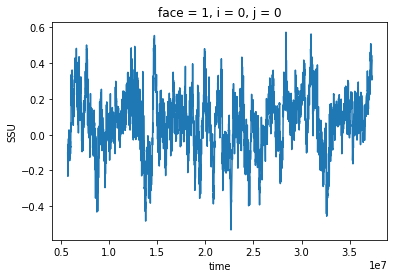

In [17]:
lds[v].isel(i=0,j=0).plot()

In [18]:
it = slice(500,1000)
lds = ds.isel(time=it)

In [ ]:
v_low = filt(lds[v])
v_2 = filt(lds[v], omega=2.)
print(v_low)

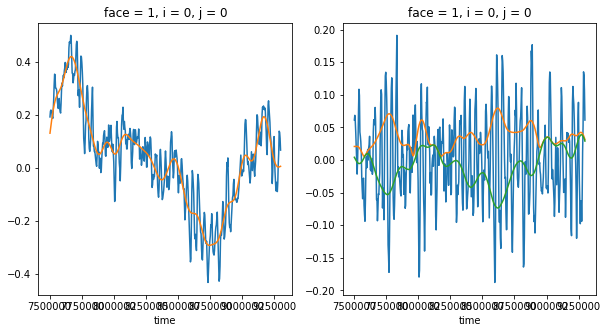

In [20]:

fig = plt.figure(figsize=(10,5))
#
ax = plt.subplot(121)
lds[v].isel(i=0,j=0).plot(ax=ax)
v_low.isel(i=0,j=0).plot(ax=ax)
#
ax = plt.subplot(122)
(lds[v] - v_low).isel(i=0,j=0).plot(ax=ax)
np.abs(v_2).isel(i=0,j=0).plot(ax=ax)
np.real(v_2).isel(i=0,j=0).plot(ax=ax)

---

## filtering over the entire tile

In [21]:
it = slice(500-Nh,500+Nh)
lds = ds.isel(time=it)

In [22]:
v_low = filt(lds[v])
v_2 = filt(lds[v], omega=2.)

In [23]:
print(v_2)

<xarray.DataArray (j: 4320, i: 4320, time: 240)>
dask.array<shape=(4320, 4320, 240), dtype=complex64, chunksize=(96, 32, 240)>
Coordinates:
    dtime      (time) datetime64[ns] dask.array<shape=(240,), chunksize=(240,)>
    face       int64 1
  * i          (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j          (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * time       (time) float64 7.07e+06 7.074e+06 7.078e+06 7.081e+06 ...
    time_days  (time) float64 dask.array<shape=(240,), chunksize=(240,)>


In [24]:
lv =  ds0[v].isel(time=it.start+Nh)
lv = lv.persist()

Text(0.5,1,'SSU')

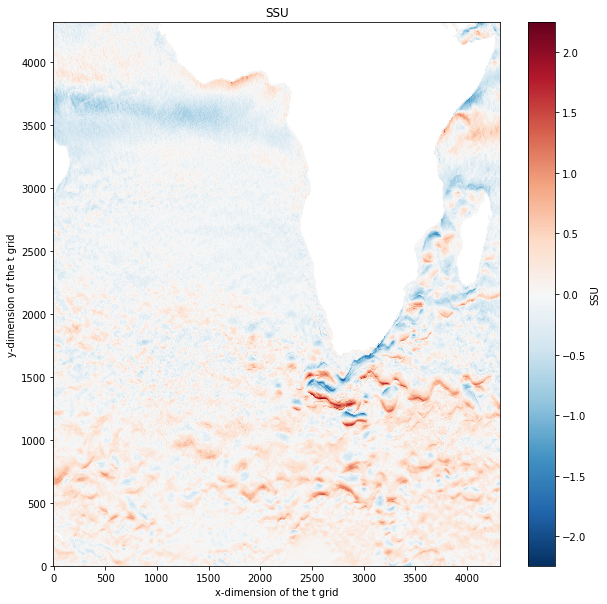

In [25]:
fig=plt.figure(figsize=(10,10))
ax=plt.subplot(111)
lv.plot(ax=ax, x='i', y='j')
ax.set_title(v)

In [26]:
lv_low = v_low.isel(time=Nh).persist()

In [27]:
lv_2 = v_2.isel(time=Nh).persist()

Text(0.5,1,'band SSU')

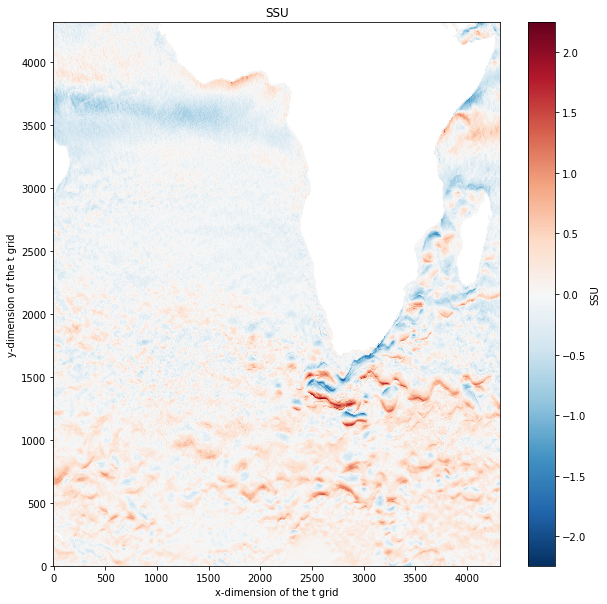

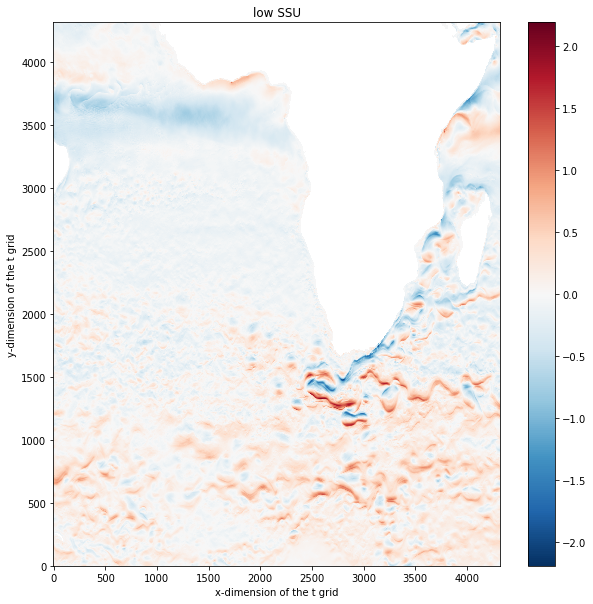

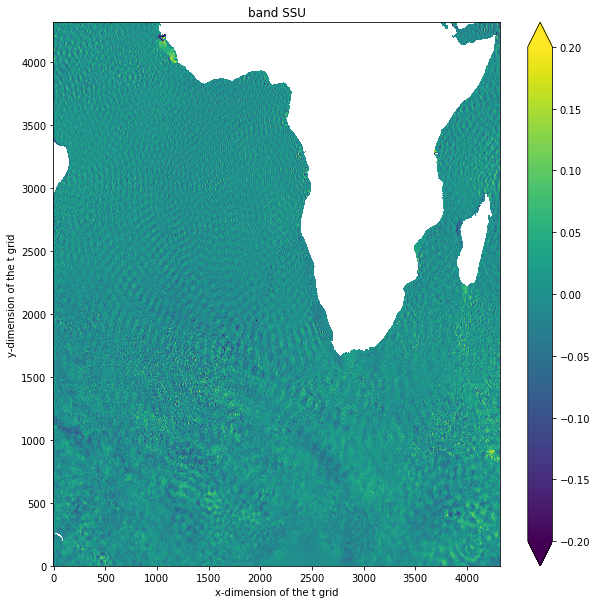

In [28]:

#
plt.figure(figsize=(10,10))
ax=plt.subplot(111)
lv.plot(ax=ax, x='i', y='j')
ax.set_title(v)

#
plt.figure(figsize=(10,10))
ax=plt.subplot(111)
lv_low.plot(ax=ax, x='i', y='j')
ax.set_title('low '+v)

#
plt.figure(figsize=(10,10))
ax=plt.subplot(111)
np.real(lv_2).plot(ax=ax, x='i', y='j', vmin=-.2, vmax=.2)
ax.set_title('band '+v)


In [29]:
del lv, lv_low, lv_2

---

In [30]:
ds

<xarray.Dataset>
Dimensions:    (i: 4320, j: 4320, time: 8785)
Coordinates:
    dtime      (time) datetime64[ns] dask.array<shape=(8785,), chunksize=(8785,)>
    face       int64 1
  * i          (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j          (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * time       (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 ...
    time_days  (time) float64 dask.array<shape=(8785,), chunksize=(8785,)>
Data variables:
    SSU        (time, j, i) float32 dask.array<shape=(8785, 4320, 4320), chunksize=(8785, 96, 32)>

In [ ]:
# store in netcdf files

Nt0 = ds.time.size
Nt = 24*5 # time windows to consider
fsize_bound = 1e20
it = np.arange(Nt0/Nt-1).astype(int)*Nt
assert it[-1]+Nt<Nt0
#
#for face in range(ds['face'].size):
for i, t in enumerate(it):
    #
    file_out = out_dir+'/%s_filtered_f%02d_t%02d.nc'%(v, face, i)
    if not os.path.isfile(file_out) or os.path.getsize(file_out) < fsize_bound:
        lds = ds.isel(time=slice(max(0,t-Nh),min(t+Nt+Nh,Nt0)))
        imin = 0 if t<Nh else Nh
        dv = filt(lds[v], omega=2.).isel(time=slice(imin,Nh+Nt))
        #
        dv = dv.chunk({'time': dv['time'].size, 'i': 432, 'j': 432})
        chunksizes = [432, 432, dv['time'].size]
        #
        dv = dv.load() # this may be required in order to prevent pickle related errors
        #
        while True:
            try:
                %time dv.to_netcdf(file_out, mode='w', unlimited_dims=['time'], \
                                   encoding={'Eta': {'chunksizes': chunksizes}})
            except:
                print('Failure')
            break
            #if os.path.isfile(file_out) and os.path.getsize(file_out)>fsize_bound:
            #    #
            #    print('face=%d / i=%d'%(face,i))
            #    break
    else:
        print('face=%d / i=%d - allready processed'%(face,i))

---

In [27]:
# add workers
w = cluster.start_workers(10)

In [ ]:
# kill scheduler, workers
cluster.scheduler.close()
#cluster.stop_workers(cluster.jobs)

In [ ]:
# restart workers
client.restart()

In [ ]:
client